In [1]:
from email.mime import image
import os
from turtle import shape
from unicodedata import numeric 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers as ksl
import numpy as np
import sklearn as sk
import pandas as pd
import cv2 as cv
from glob import glob


In [7]:

class Model():
    def __init__(self,loadWeights = False,loadModel = False,weightAddr = None,modelAddr=None):
        if loadModel:
            self.net = self.loadModel(modelAddr)
        elif not(loadModel and loadWeights):
            self.net = self.buildModel()
        elif loadWeights:
            self.net = self.loadWeights()
            self.loadWeights(weightAddr)
        else :
            print('[Error] incompatible inputs !')
        self.bedroom = []
        self.bathroom = []
        self.frontal = []
        self.kitchen =  [] 
        self.txtFeatur = []
        self.const = None
        self.label = []
        self.const = []
        self.label = []
        
    def split(self):
        split = sk.modelselection.train_test_split(self.bedroom,self.bathroom,self.frontal,self.kitchen,self.txtFeatur,self.label,test_size = 0.2)
        return split
    def loadData(self,txtPath,imgPath):
        self.txtFeatur = pd.DataFrame([[float(t) for t in x.split('\n')[0].split(' ')] for x in open(txtPath).readlines()])
        self.txtFeatur.T.loc[[0,1,2,3],:]
        self.label = self.txtFeatur.loc[:,4] 
        self.txtFeatur = self.txtFeatur.T.loc[[0,1,2,3],:].T 
        max = self.txtFeatur.max()
        self.txtFeatur = self.txtFeatur/max
        self.const = np.max(self.label)
        self.label = self.label/self.const


        for i,p in enumerate(glob(imgPath+'/*')):
            place = p.split('/')[-1].split('.')[0].split('_')[1]
            if place == 'bedroom':
                self.bedroom.append(self.preProcess(cv.imread(p)))
            elif place == 'bathroom':
                self.bathroom.append(self.preProcess(cv.imread(p)))
            elif place == 'frontal':
                self.frontal.append(self.preProcess(cv.imread(p)))
            else:
                self.kitchen.append(self.preProcess(cv.imread(p)))
            if i%500 == 0:
                print('[INFO] {}th image loaded'.format(i))
        self.bedroom = np.array(self.bedroom)
        self.bathroom = np.array(self.bathroom)
        self.frontal = np.array(self.frontal)
        self.kitchen = np.array(self.kitchen)

    def myLoss(y_true,y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred),axis = -1)
    def compile(self,loss,metrics,optim):
        self.net.compile(loss = loss,optimizer = optim ,metrics = metrics)

    def train(self,e,b):
        hist = self.net.fit([self.bedroom,self.bathroom,self.frontal,self.kitchen,self.txtFeatur],self.label,epochs = e,batch_size = b)
        return hist

    def buildModel(self):
        inpIm1 = ksl.Input((128,128,3),name = 'image1Input')
        inpIm2 = ksl.Input((128,128,3),name = 'image2Input')
        inpIm3 = ksl.Input((128,128,3),name = 'image3Input')
        inpIm4 = ksl.Input((128,128,3),name = 'image4Input')
        
        x = ksl.Conv2D(32,kernel_size=3,strides=1,padding='same')(inpIm1)
        x = ksl.Lambda(self.relu)(x)
        x = ksl.MaxPool2D([2,2])(x)
        x = ksl.Conv2D(64,kernel_size=3,padding='same')(x)
        x = ksl.Lambda(self.relu)(x)
        x = ksl.MaxPool2D([2,2])(x)
        x = ksl.Conv2D(128,kernel_size=3,padding='same')(x)
        x = ksl.Lambda(self.relu)(x)
        x = ksl.MaxPool2D([2,2])(x)

        w = ksl.Conv2D(32,kernel_size=3,strides=1,padding='same')(inpIm2)
        w = ksl.Lambda(self.relu)(w)
        w = ksl.MaxPool2D([2,2])(w)
        w = ksl.Conv2D(64,kernel_size=3,padding='same')(w)
        w = ksl.Lambda(self.relu)(w)
        w = ksl.MaxPool2D([2,2])(w)
        w = ksl.Conv2D(128,kernel_size=3,padding='same')(w)
        w = ksl.Lambda(self.relu)(w)
        w = ksl.MaxPool2D([2,2])(w)

        y = ksl.Conv2D(32,kernel_size=3,strides=1,padding='same')(inpIm3)
        y=ksl.Lambda(self.relu)(y)
        y = ksl.MaxPool2D([2,2])(y)
        y = ksl.Conv2D(64,kernel_size=3,padding='same')(y)
        y = ksl.Lambda(self.relu)(y)
        y = ksl.MaxPool2D([2,2])(y)
        y = ksl.Conv2D(128,kernel_size=3,padding='same')(y)
        y = ksl.Lambda(self.relu)(y)
        y = ksl.MaxPool2D([2,2])(y)

        z = ksl.Conv2D(32,kernel_size=3,strides=1,padding='same')(inpIm4)
        z = ksl.MaxPool2D([2,2])(z)
        z = ksl.Conv2D(64,kernel_size=3,padding='same')(z)
        z = ksl.MaxPool2D([2,2])(z)
        z = ksl.Conv2D(64,kernel_size=3,padding='same')(z)
        z = ksl.MaxPool2D([2,2])(z)
        

        inpTxtFeatures = ksl.Input((4,),name = 'numFeatureInput')
        t = ksl.Dense(1024,'relu')(inpTxtFeatures)
        t = ksl.Dense(512,'relu')(t)
        t = ksl.Dense(256,'relu')(t)
        t = ksl.Reshape((16,16,1))(t)



        concatInput = ksl.concatenate([w,x,y,z,t],axis=3)
        out = ksl.Conv2D(128,kernel_size=3,padding='same')(concatInput)
        out = ksl.MaxPool2D([2,2])(out)
        out = ksl.Conv2D(256,kernel_size=3,padding='same')(out)
        out = ksl.MaxPool2D([2,2])(out)
        out = ksl.Flatten()(out)
        out = ksl.Dense(128,'relu')(out)
        out = ksl.Dense(64,'relu')(out)
        out = ksl.Dense(1,'linear')(out)
        net = tf.keras.Model(inputs = [inpIm1,inpIm2,inpIm3,inpIm4,inpTxtFeatures],outputs = out)
        return net
    def predict(self,inputList):
        numericFeatur = inputList[4:]
        numericFeatur = pd.DataFrame(numericFeatur)
        max = numericFeatur.max()
        numericFeatur = numericFeatur/max
        images = inputList[:4]
        images = [self.preProcess(im) for im in images]
        pred = self.net.predict(np.concatenate((images,numericFeatur.to_numpy())))
        return pred*self.const

    def saveModel(self,addr):
        self.net.save(addr+'/model.h5')
        self.net.save_weights(addr+'/modelWeights.h5')
    def loadWeights(self,weightAddr):
        net = self.buildModel()
        net.load_weghts(weightAddr)
        return net
    @staticmethod
    def loadModel(modelAddr):
        net = tf.kerasl.models.load_model(modelAddr)
        return net

    @staticmethod
    def preProcess(image):
        image = cv.resize(image,(128,128))
        image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
        image = image/255.0

        return image
    @staticmethod
    def relu(x):
        return tf.maximum( 0.0,x)
    @staticmethod
    def plotHistory(Hist):
        # plot History
        plt.plot(Hist.history['loss'])
        plt.title('model loss')
        plt.show()
        plt.plot(Hist.history['mse'])
        plt.title('model mse')
        plt.show()



In [12]:
model = Model()
txtPath = r'/content/drive/MyDrive/HousePricePredictionData/Data/HousesInfo.txt'
imgPath = r'/content/drive/MyDrive/HousePricePredictionData/Data/house_dataset'


In [13]:
model.loadData(txtPath=txtPath,imgPath=imgPath)
model.compile(loss = 'mse',metrics = ['mse'],optim = tf.keras.optimizers.Adam(learning_rate = 0.001))

[INFO] 0th image loaded
[INFO] 500th image loaded
[INFO] 1000th image loaded
[INFO] 1500th image loaded
[INFO] 2000th image loaded


In [14]:
Hist = model.train(50,64)

Epoch 1/50
9/9 [==============================] - 2s 139ms/step - loss: 0.8504 - mse: 0.8504
Epoch 2/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0117 - mse: 0.0117
Epoch 3/50
9/9 [==============================] - 1s 137ms/step - loss: 0.0158 - mse: 0.0158
Epoch 4/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0106 - mse: 0.0106
Epoch 5/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0089 - mse: 0.0089
Epoch 6/50
9/9 [==============================] - 1s 137ms/step - loss: 0.0076 - mse: 0.0076
Epoch 7/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0076 - mse: 0.0076
Epoch 8/50
9/9 [==============================] - 1s 139ms/step - loss: 0.0084 - mse: 0.0084
Epoch 9/50
9/9 [==============================] - 1s 139ms/step - loss: 0.0073 - mse: 0.0073
Epoch 10/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0079 - mse: 0.0079
Epoch 11/50
9/9 [==============================] - 1s 138ms/step - lo

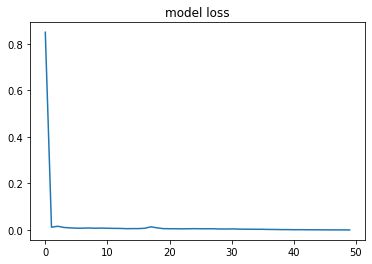

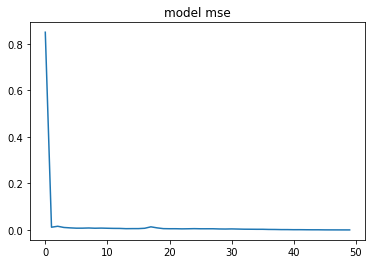

In [15]:
model.plotHistory(Hist)

In [16]:
model.saveModel('/content/drive/MyDrive/Models')